In this notebook, we are going to learn how to use the TME filter and smoother in `jax`. 

First, let us import necessary packages and dependencies. Note that you need to have `tmefs` installed beforehand.

In [17]:
import math
import jax
import jax.numpy as jnp
import tme.base_jax as tme
import matplotlib.pyplot as plt

from jax import jit
from jax.config import config

from tmefs.filters_smoothers import sgp_filter, sgp_smoother
from tmefs.quadratures import SigmaPoints
from tmefs.tools import gen_sample

config.update("jax_enable_x64", True)

Write down the Lorenz SDE and the measurement model (see detailed equations in the manuscript).

In [18]:
dim_x = 3
kappa = 10.
lam = 28.
mu = 2.
sigma = 5.
H = jnp.array([[1., 0., 0.]]) # Measurement model
R = 2.


# Here defines our SDE
@jit
def drift(u):
    return jnp.array([kappa * (u[1] - u[0]),
                      u[0] * (lam - u[2]) - u[1],
                      u[0] * u[1] - mu * u[2]])


@jit
def dispersion(u):
    return sigma * jnp.eye(3)


# Here creates the TME (order 2) approximation of the SDE
tme_order = 2
@jit
def tme_m_cov(u, dt):
    return tme.mean_and_cov(x=u, dt=dt,
                            drift=drift, dispersion=dispersion, order=tme_order)


@jit
def em_m_cov(u, dt):
    return u + drift(u) * dt, dispersion(u) @ dispersion(u).T * dt


m0 = jnp.zeros((dim_x,))
P0 = 10. * jnp.eye(dim_x)

sgps = SigmaPoints.gauss_hermite(d=dim_x, order=3)

dt = 0.02
end_t = 2.
num_steps = 100

Compile the filter and smoother.

In [19]:
@jit
def jitted_filter(ys):
    return sgp_filter(f_Q=tme_m_cov, sgps=sgps,
                      H=H, R=R,
                      m0=m0, P0=P0, dt=dt, ys=ys)


@jit
def jitted_smoother(mfs, Pfs):
    return sgp_smoother(f_Q=tme_m_cov, sgps=sgps, mfs=mfs, Pfs=Pfs,
                        dt=dt)

Simlulate a pair of trajectory and measurements/data from the model.

In [20]:
seed = 666 + 0

# Simulate data
key = jax.random.PRNGKey(seed)
key, subkey = jax.random.split(key)
x0 = jax.random.multivariate_normal(key=subkey, mean=m0, cov=P0)
key, subkey = jax.random.split(key)
ts, true_x = gen_sample(m_and_cov=em_m_cov, x0=x0, dt=dt, end_t=end_t,
                        num_steps=num_steps, int_steps=10000,
                        key=subkey)
key, subkey = jax.random.split(key)
ys = jnp.einsum('ij,...j->...i', H, true_x).reshape(-1) \
     + math.sqrt(R) * jax.random.normal(subkey, shape=(ts.size,))

Run the filter and smoother. Note that the first run might take a while because `jax` needs to compile them.

In [21]:
filtering_results = jitted_filter(ys)
smoothing_results = jitted_smoother(filtering_results[0], filtering_results[1])

Plot the results.

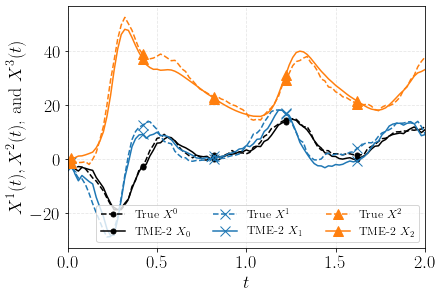

In [22]:
plt.rcParams.update({
    'text.usetex': True,
    'font.family': "san-serif",
    'font.size': 18})

for id, marker, colour in zip([0, 1, 2], ['.', 'x', '^'], ['black', 'tab:blue', 'tab:orange']):
    plt.plot(ts, true_x[:, id], c=colour, marker=marker, markevery=20, markersize=10,
             linestyle='--', label=f'True $X^{id}$')
    plt.plot(ts, filtering_results[0][:, id], c=colour, marker=marker, markevery=20, markersize=10,
             linestyle='-', label=f'TME-{tme_order} $X_{id}$')

plt.grid(linestyle='--', alpha=0.3, which='both')

plt.ylabel('$X^1(t), X^2(t)$, and $X^3(t)$')
plt.xlabel('$t$')
plt.xlim(0, end_t)

plt.legend(ncol=3, fontsize=12, loc='lower right')

plt.tight_layout(pad=0.1)